## RestNet50 & CNN

###  Import Necessary Libraries

In [ ]:
# Import necessary libraries
#!pip install visualkeras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D, Dense
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
#from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
import os
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#import visualkeras
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from google.colab import drive
drive.mount('/content/drive')

### Load and Preprocess the CIFAR-10 Dataset

#### Load data cifar10

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#### Then, let's split original training data to training and validation sets:

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

#### printing out the dimensions of our training, validation, and test datasets:

In [ ]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


#### take an overview of the CIFAR-10 dataset:

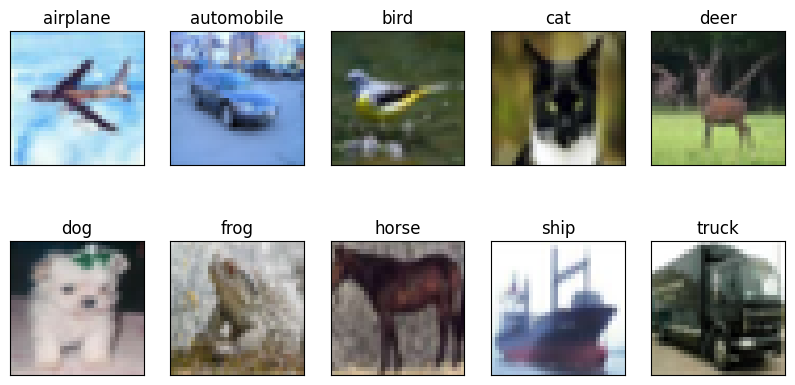

In [ ]:
# plotting some random 10 images

num_classes = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(10,5))
for i in range(len(num_classes)):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = (features_idx[img_num,::])
    ax.set_title(num_classes[i])
    plt.imshow(im)
plt.show()

#### Class distribution in training set

Text(0.5, 1.0, 'Class distribution in training set')

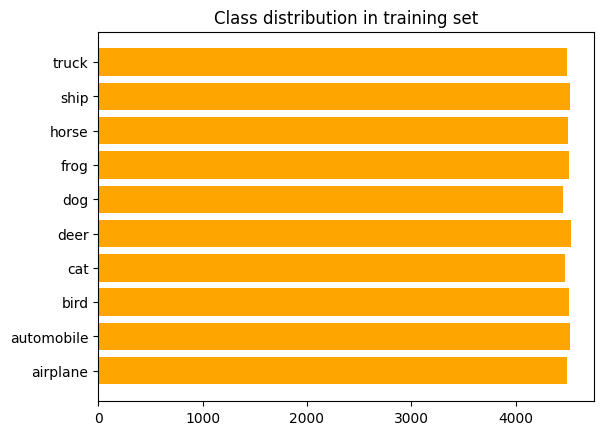

In [ ]:
classes, counts = np.unique(y_train, return_counts=True)
plt.barh(num_classes, counts, color='orange')
plt.title('Class distribution in training set')

#### Class distribution in testing set

Text(0.5, 1.0, 'Class distribution in testing set')

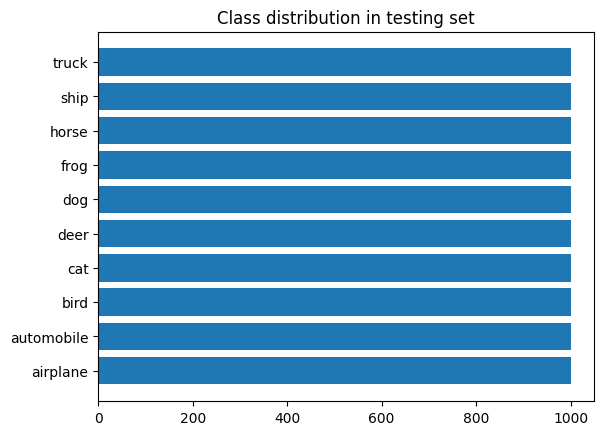

In [ ]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(num_classes, counts)
plt.title('Class distribution in testing set')

#### Class distribution in validation set

Text(0.5, 1.0, 'Class distribution in validation set')

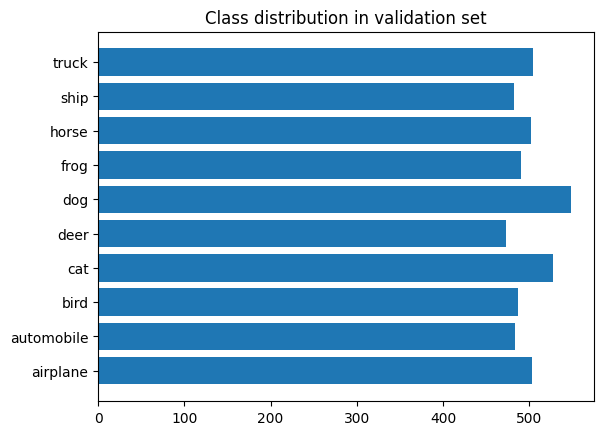

In [ ]:
classes, counts = np.unique(y_valid, return_counts=True)
plt.barh(num_classes, counts)
plt.title('Class distribution in validation set')

#### Normalization of Image Data

In [ ]:
# Convert pixel values data type to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train)
std  = np.std(X_train)

# Standardization or Z-Score Normalization
X_train = (X_train-mean)/(std+1e-7)########################### احدفو لانو مستخدمين batch normalization اعتقد احسن
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

#### One-Hot Encoding of Labels

In [ ]:
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

#### Data Augmentation

In [ ]:
train_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.1,
)###### print sample image after datagen

'\nval_generator = ImageDataGenerator(\n    rotation_range=10,\n    width_shift_range=0.1,\n    height_shift_range=0.1,\n    horizontal_flip=True,\n    shear_range=0.1,\n    zoom_range=0.1,\n)\ntest_generator = ImageDataGenerator(\n    rotation_range=10,\n    width_shift_range=0.1,\n    height_shift_range=0.1,\n    horizontal_flip=True,\n    shear_range=0.1,\n    zoom_range=0.1,)\n    '

### ***CNN Model***

#### Define CNN Model Architecture

In [ ]:
# Initialize a sequential model
model = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay),
                 input_shape=X_train.shape[1:]))
# Add batch normalization layer
model.add(BatchNormalization())

# Add the second convolutional layer similar to the first
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the first max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))

# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Training Optimization Callbacks

In [ ]:
# Add ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

# Add ModelCheckpoint callback
model_Checkpoint = ModelCheckpoint('/content/drive/My Drive/RestNet50 & CNN/waight save/CNN/model_CNN.keras', save_best_only=True)

#### Compile the model

In [ ]:
# Compile the model with the defined optimizer, loss function, and metrics
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

#### Training the CNN Model

In [ ]:
# Fit the model on the training data, using the defined batch size and number of epochs
history = model.fit(
      train_generator.flow(X_train, y_train, batch_size=64),
      epochs=300,
      validation_data=(X_valid, y_valid),
      callbacks=[reduce_lr, early_stopping, model_Checkpoint],
      verbose=2
)

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 - 75s - 106ms/step - accuracy: 0.3416 - loss: 2.3133 - val_accuracy: 0.4730 - val_loss: 1.5618 - learning_rate: 5.0000e-04
Epoch 2/300
704/704 - 58s - 82ms/step - accuracy: 0.4809 - loss: 1.6714 - val_accuracy: 0.5356 - val_loss: 1.5481 - learning_rate: 5.0000e-04
Epoch 3/300
704/704 - 36s - 51ms/step - accuracy: 0.5484 - loss: 1.4562 - val_accuracy: 0.5996 - val_loss: 1.1988 - learning_rate: 5.0000e-04
Epoch 4/300
704/704 - 37s - 53ms/step - accuracy: 0.5945 - loss: 1.2868 - val_accuracy: 0.6198 - val_loss: 1.2752 - learning_rate: 5.0000e-04
Epoch 5/300
704/704 - 35s - 49ms/step - accuracy: 0.6406 - loss: 1.1554 - val_accuracy: 0.7092 - val_loss: 0.9190 - learning_rate: 5.0000e-04
Epoch 6/300
704/704 - 42s - 59ms/step - accuracy: 0.6710 - loss: 1.0577 - val_accuracy: 0.6950 - val_loss: 1.0019 - learning_rate: 5.0000e-04
Epoch 7/300
704/704 - 41s - 58ms/step - accuracy: 0.6978 - loss: 0.9801 - val_accuracy: 0.7136 - val_loss: 0.9386 - learning_rate: 5.0000e-04
Epoch 8/300
704/7

#### Save Training History For CNN

In [ ]:
# Save the training history JSON file to Google Drive
history_path = '/content/drive/My Drive/RestNet50 & CNN/History save/CNN/history_CNN.json'  # Specify the path in Google Drive
with open(history_path, 'w') as f:
    json.dump(history.history, f)

#### Load the saved model For CNN

In [ ]:
# Load the saved model
model_path = '/content/drive/My Drive/RestNet50 & CNN/waight save/CNN/model_CNN.keras'
model = load_model(model_path)

#### load the training history For CNN

In [ ]:
# Load training history from the JSON file
with open('/content/drive/My Drive/RestNet50 & CNN/History save/CNN/history_CNN.json', 'r') as f:
    history = json.load(f)

#### Visualizing our model (Hidden Input)


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


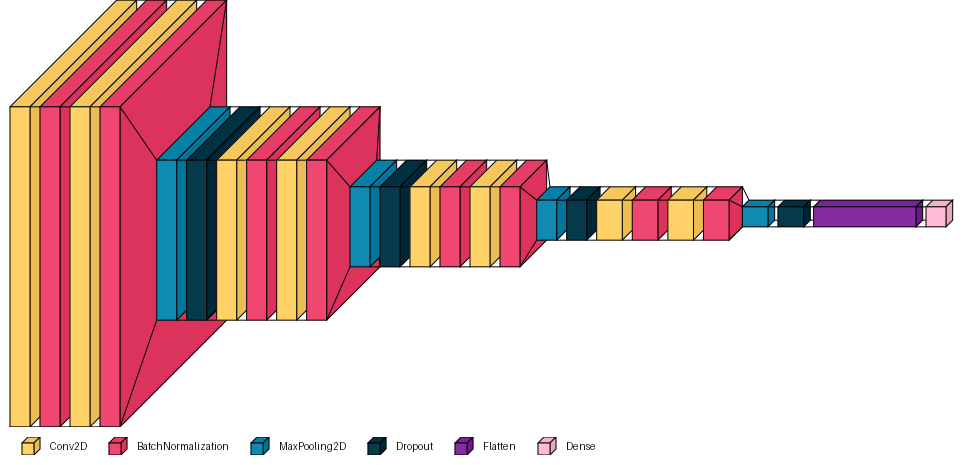

In [ ]:
visualkeras.layered_view(model, scale_xy=10, legend=True)

####  display the detailed architecture of the model:

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,555,200 (13.56 MB)

 Trainable params: 1,184,426 (4.52 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 2,368,854 (9.04 MB)

#### Visualizing the Learning Curves

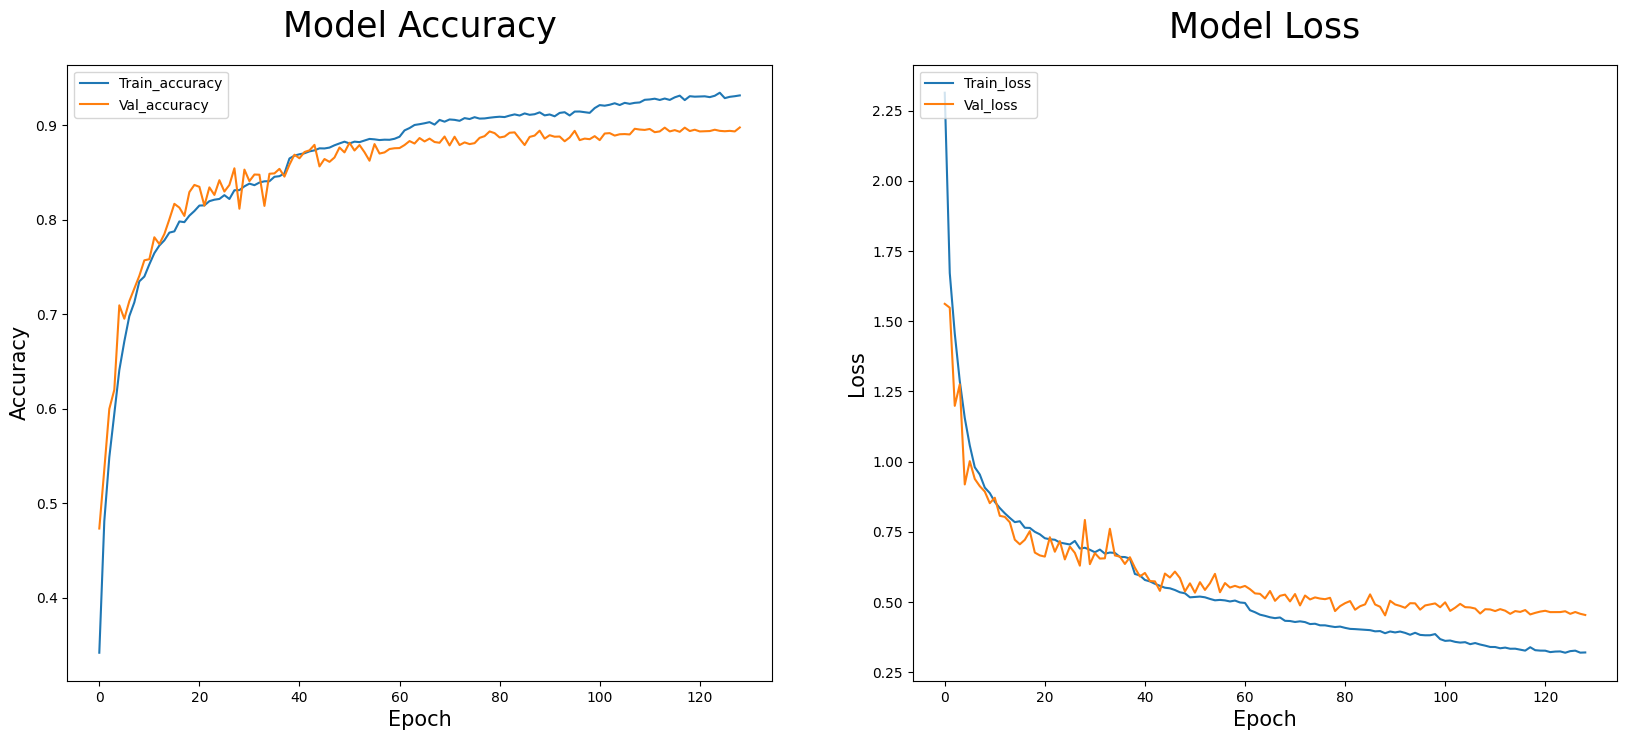

In [ ]:
# Plotting the Model Accuracy & Model Loss vs Epochs (Hidden Input)
plt.figure(figsize=[20,8])

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['Train_accuracy', 'Val_accuracy'], loc='upper left')
# summarize history for loss

plt.subplot(1,2,2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['Train_loss', 'Val_loss'], loc='upper left')
plt.show()

#### Model Evaluation For CNN

In [ ]:
# Use the model to make predictions, evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print(f'\nTest Accuracy:, {test_acc:.2f}')
print(f'Test Loss:    , {test_loss:.2f}')

313/313 - 35s - 111ms/step - accuracy: 0.8984 - loss: 0.4650

Test Accuracy:, 0.90
Test Loss:    , 0.46


#### Classification Report For CNN

In [ ]:
# Predict the classes for the test set
predictions = model.predict(X_test)

# Get true and predicted labels
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=num_classes)
print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step
              precision    recall  f1-score   support

    airplane       0.91      0.91      0.91      1000
  automobile       0.94      0.97      0.96      1000
        bird       0.88      0.88      0.88      1000
         cat       0.82      0.75      0.79      1000
        deer       0.88      0.89      0.89      1000
         dog       0.89      0.80      0.84      1000
        frog       0.85      0.97      0.90      1000
       horse       0.95      0.92      0.93      1000
        ship       0.95      0.94      0.94      1000
       truck       0.91      0.95      0.93      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



#### Confusion Matrix Visualization For CNN

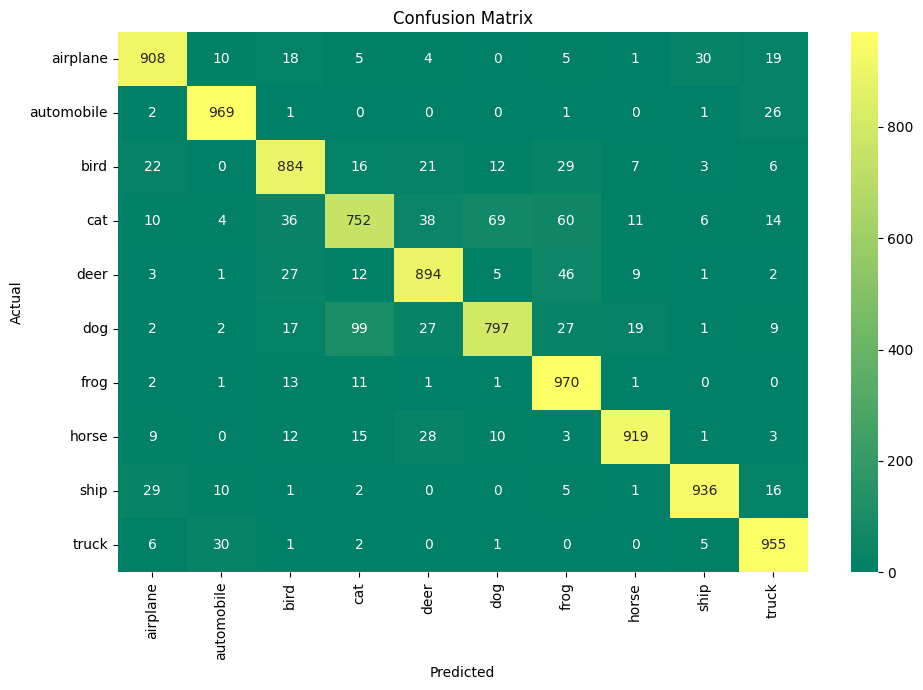

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='summer', xticklabels=num_classes, yticklabels=num_classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()  # Ensure the labels are correctly placed
plt.show()

#### Display Sample Predictions

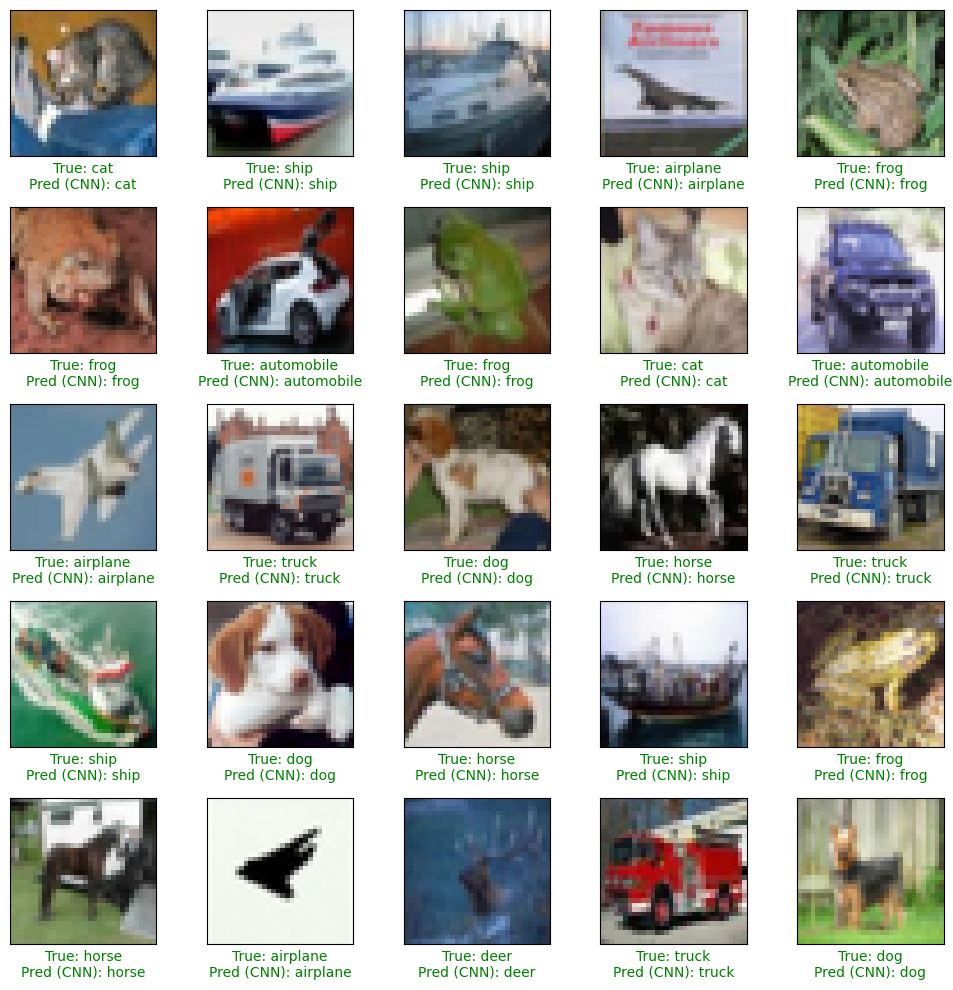

In [ ]:
# Get predictions for the test set
predicted_labels_cnn = np.argmax(predictions, axis=1)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Plot sample images with predicted labels
plt.figure(figsize=(10, 10))
for i in range(25):  # Adjust as needed
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])  # Plot original image
    true_label = num_classes[y_test[i][0]]  # Get true label
    predicted_label = num_classes[predicted_labels_cnn[i]]  # Get predicted label
    if true_label == predicted_label:
        color = 'green'  # Correct prediction
    else:
        color = 'red'  # Incorrect prediction
    plt.xlabel(f"True: {true_label}\nPred (CNN): {predicted_label}", color=color)
plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.show()

### ***ResNet50 model***

### Load and Preprocess the CIFAR-10 Dataset

#### *NOTE*

In [ ]:
'''
1-
اعتقد غلط تعمل -> min max
لازم تشوف شو الطريقه العملو الها تطبيع حتى تكون صورك مثل صور التي تدرب عليها النمودج .

2-
الصور التي تدرب عليها النمودج 224*224*3
فلازم تكبر حجم الصور من 32 الى 224  باستخدام
Upsamling وتضرب ب (7,7) -> هاي اسم فانكشن

3-
خزن الصور عالدرايف او اي مكان حتى مش كل مره ترجع تعملهم
استخدم v2-8 tpu تبع google colab بعطيك ram 355
بعد ما تخزنهم ارجع استخدم gpu
واستدعيهم من الملفات

4-
جرب sprase_categorical_crossentropy حكى الدكتور loss
اخف لانو هداك على 1000 كلاس

5-
لا نسنخدم dropout
مع النمادج المدرب لانو هيك بنستثني اوزان مدربه

'''

'\n1-\nاعتقد غلط تعمل -> min max \nلازم تشوف شو الطريقه العملو الها تطبيع حتى تكون صورك مثل صور التي تدرب عليها النمودج .\n\n2-\nالصور التي تدرب عليها النمودج 224*224*3\nفلازم تكبر حجم الصور من 32 الى 224  باستخدام \nUpsamling وتضرب ب (7,7) -> هاي اسم فانكشن\n\n3-\nجرب sprase_categorical_crossentropy حكى الدكتور loss\nاخف لانو هداك على 1000 كلاس \n\n4- لا نسنخدم dropout مع النمادج المدرب لانو هيك بنستثني اوزان مدربه \n'

In [ ]:
help(UpSampling2D) ## شوف كيف طريقه تكبير الصوره

#### Load data cifar10

In [ ]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Normalize images to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


### One-Hot Encode

In [ ]:
# One-hot encode the labels for categorical classification
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("x_val shape:", x_val.shape)

x_train shape: (45000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
x_val shape: (5000, 32, 32, 3)


### Load the pre-trained ResNet50 model

In [ ]:
# Load the pre-trained ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze specific layers in the base model
for layer in base_model.layers[-7:]:
    layer.trainable = False

# Add custom layers for CIFAR-10 classification
x = base_model.output
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x) #### -> note up

x = GlobalAveragePooling2D()(x)
x = Dense(num_classes, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Compile the model and schedule


In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

#### Set up callbacks


In [ ]:
# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint('/content/drive/My Drive/RestNet50 & CNN/waight save/RestNet50/model_ResNet50.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5),
]

#### Data Augmentation

In [ ]:
# Define the data augmentation generator for training data
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

#### Train the ResNet50 model


In [ ]:
# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=40,
    validation_data=(x_val, y_val),  # Use validation data properly
    callbacks=callbacks,
    verbose=1
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 119s 100ms/step - accuracy: 0.4877 - loss: 1.6232 - val_accuracy: 0.2786 - val_loss: 2.4740 - learning_rate: 5.0000e-04
Epoch 2/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 104s 72ms/step - accuracy: 0.7091 - loss: 0.8818 - val_accuracy: 0.6928 - val_loss: 0.9098 - learning_rate: 5.0000e-04
Epoch 3/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 51s 72ms/step - accuracy: 0.7443 - loss: 0.7738 - val_accuracy: 0.7670 - val_loss: 0.6814 - learning_rate: 5.0000e-04
Epoch 4/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 67ms/step - accuracy: 0.7718 - loss: 0.6923 - val_accuracy: 0.6984 - val_loss: 0.9661 - learning_rate: 5.0000e-04
Epoch 5/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 83s 68ms/step - accuracy: 0.7804 - loss: 0.6614 - val_accuracy: 0.6942 - val_loss: 1.1500 - learning_rate: 5.0000e-04
Epoch 6/40
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7952 - loss: 0.6216
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
704/704 ━━━━━━━━━━━━━━━━━━━━ 49s 69ms/step - accuracy: 

#### Save the training history

In [ ]:
# Save the training history JSON file to Google Drive
history_path = '/content/drive/My Drive/RestNet50 & CNN/History save/RestNet50/history_ResNet50.json'  # Specify the path in Google Drive
with open(history_path, 'w') as f:
    json.dump(history.history, f)

#### Load the saved model


In [ ]:
# Load the saved model
model_path = '/content/drive/My Drive/RestNet50 & CNN/waight save/RestNet50/model_ResNet50.keras'
model = load_model(model_path)

#### Load training history

In [ ]:
# Load training history from the JSON file
with open('/content/drive/My Drive/RestNet50 & CNN/History save/RestNet50/history_ResNet50.json', 'r') as f:
    history = json.load(f)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 66,988,448 (255.54 MB)

 Trainable params: 21,173,258 (80.77 MB)

 Non-trainable params: 3,468,672 (13.23 MB)

 Optimizer params: 42,346,518 (161.54 MB)

#### Classification Report For ResNet50

In [ ]:
# Predict on the test set
predictions = model.predict(x_test)

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Calculate true and predicted labels
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)

# Print classification report and accuracy
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


score = model.evaluate(x_test,y_test,verbose=0)

print('Test Loss : {:.2f}'.format(score[0]))
print('Test Accuracy : {:.2f}'.format(score[1]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 174s 538ms/step
              precision    recall  f1-score   support

    airplane       0.86      0.91      0.88      1000
  automobile       0.90      0.93      0.91      1000
        bird       0.84      0.81      0.82      1000
         cat       0.78      0.66      0.71      1000
        deer       0.83      0.86      0.84      1000
         dog       0.84      0.74      0.79      1000
        frog       0.81      0.95      0.87      1000
       horse       0.87      0.91      0.89      1000
        ship       0.94      0.90      0.92      1000
       truck       0.89      0.91      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.86      0.85     10000

Test Loss : 0.47
Test Accuracy : 0.86


#### confusion matrix for ResNet50

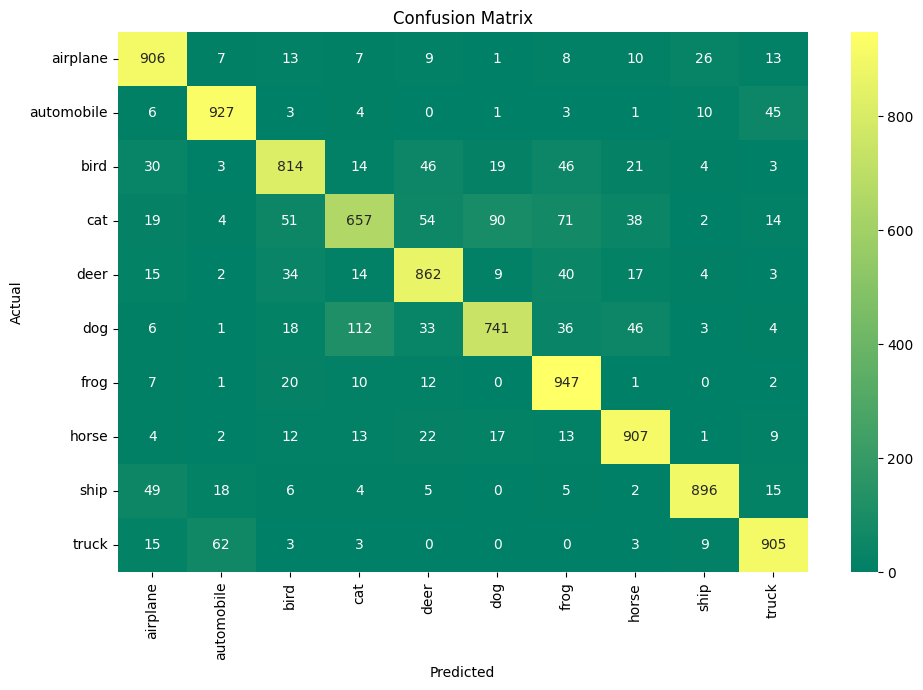

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='summer', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

#### Visualizing the Learning Curves

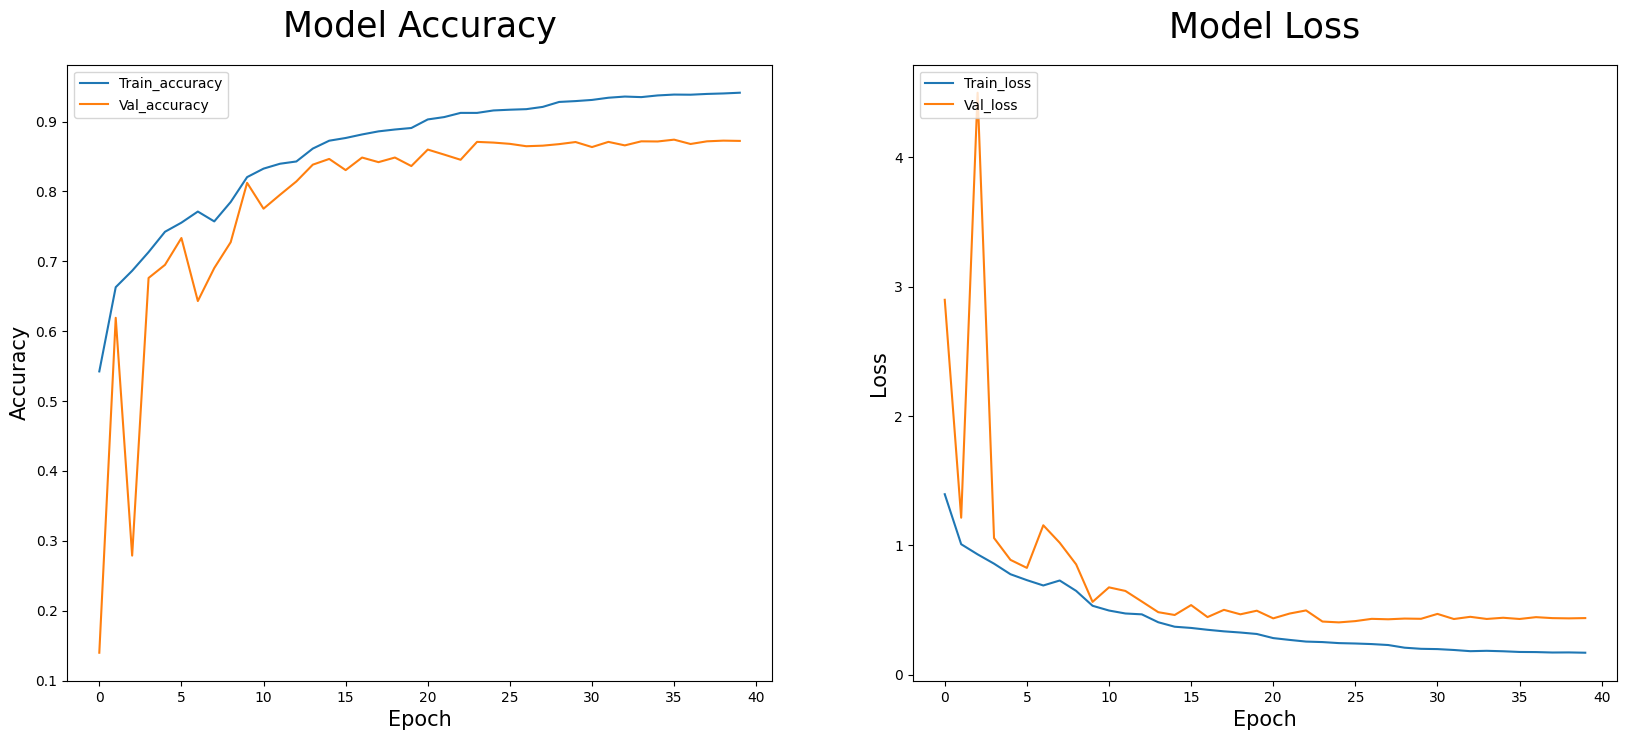

In [ ]:
# Plotting the Model Accuracy & Model Loss vs Epochs (Hidden Input)
plt.figure(figsize=[20,8])

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['Train_accuracy', 'Val_accuracy'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['Train_loss', 'Val_loss'], loc='upper left')
plt.show()

#### Display Sample Predictions

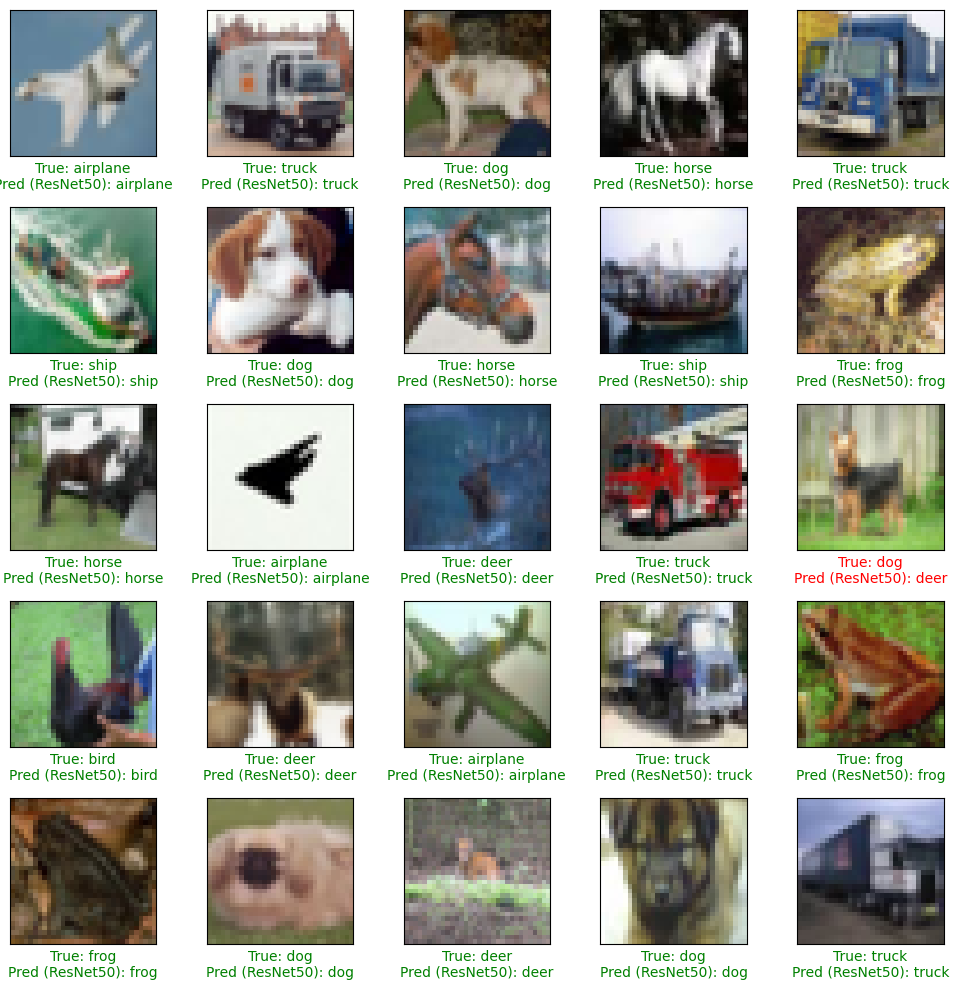

In [ ]:
# Get predictions for the test set
predicted_labels_ResNet50 = np.argmax(predictions, axis=1)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Plot sample images with predicted labels
plt.figure(figsize=(10, 10))
for i in range(10, 35):
    plt.subplot(5, 5, i - 9)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])  # Plot original image
    true_label = class_names[y_test[i][0]]  # Get true label
    predicted_label = class_names[predicted_labels_ResNet50[i]]  # Get predicted label
    if true_label == predicted_label:
        color = 'green'  # Correct prediction
    else:
        color = 'red'  # Incorrect prediction
    plt.xlabel(f"True: {true_label}\nPred (ResNet50): {predicted_label}", color=color)
plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.show()


#### Show a sample of predictions on a set of images from the Internet.

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


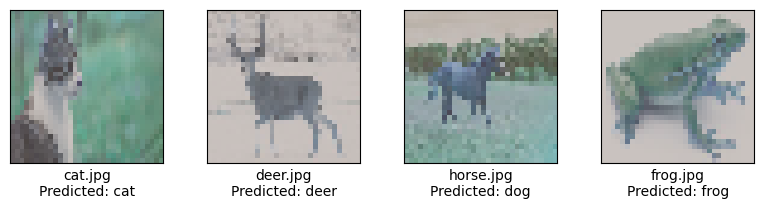

In [ ]:
# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Path to the folder containing the images
image_folder = "/content/drive/My Drive/RestNet50 & CNN/data"  # Replace with the correct path to the image folder

# Read the images from the folder
images = []
image_names = []
for image_file in os.listdir(image_folder):
    if image_file.endswith(('.png', '.jpg', '.jpeg')):  # Ensure the files are images
        img_path = os.path.join(image_folder, image_file)
        img = load_img(img_path, target_size=(32, 32))  # Load the image with the required size
        img_array = img_to_array(img)  # Convert the image to a numpy array
        img_array = preprocess_input(img_array)  # Preprocess the image for the model
        # Normalize images to the range [0, 1]
        img_array = img_array.astype('float32') / 255.0
        images.append(img_array)  # Append the processed image to the list
        image_names.append(image_file)  # Store the image name for later display

# Convert the images list to a numpy array
images = np.array(images)

# Make predictions using the model
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)  # Get the class with the highest probability

# Display the images with the predictions
plt.figure(figsize=(10, 10))
for i, img_array in enumerate(images):
    plt.subplot(5, 5, i + 1)  # Create a subplot for each image
    plt.xticks([])  # Hide the x-axis ticks
    plt.yticks([])  # Hide the y-axis ticks
    plt.grid(False)  # Disable the grid
    plt.imshow((img_array + 1) / 2)  # Revert the image back to its original color scale
    predicted_label = class_names[predicted_labels[i]]  # Get the predicted label for the image
    plt.xlabel(f"{image_names[i]}\nPredicted: {predicted_label}")  # Display the image name and predicted label
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()  # Show the plot
